In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint
import logging

In [94]:
pd.set_option('display.max_columns', None)

In [95]:
seasons_df=pd.read_pickle('data/seasons_betting_constants_df.pkl')

In [96]:
seasons_df.drop(columns=['Date', 'HomeTeam', 'AwayTeam'], inplace=True)

Only training and testing on matches that had more than 3 previous games that season

In [97]:
seasons_df=seasons_df.loc[seasons_df['home.matchNumber']>3]

In [98]:
label_encoder = LabelEncoder()
seasons_df['label'] = label_encoder.fit_transform(seasons_df['FTR'])

In [99]:
seasons_df['label'] 

36      0
37      0
38      2
39      2
40      2
       ..
8275    2
8276    2
8277    0
8278    0
8279    2
Name: label, Length: 7741, dtype: int64

In [100]:
pd.set_option('future.no_silent_downcasting', True)
seasons_df=seasons_df.fillna(0)

In [101]:
seasons_df

,FTR,home.matchNumber,away.matchNumber,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,diff.daysSince,diff.total.win,diff.total.draw,diff.total.loss,diff.total.goals,diff.total.conceded,diff.total.half_goals,diff.total.half_conceded,diff.total.shots,diff.total.shots_against,diff.total.shots_target,diff.total.shots_against_target,diff.total.corners,diff.total.corners_conceded,diff.total.fouls,diff.total.fouls_other_team,diff.total.yellows,diff.total.reds,diff.last3.win,diff.last3.draw,diff.last3.loss,diff.last3.goals,diff.last3.conceded,diff.last3.half_goals,diff.last3.half_conceded,diff.last3.shots,diff.last3.shots_against,diff.last3.shots_target,diff.last3.shots_against_target,diff.last3.corners,diff.last3.corners_conceded,diff.last3.fouls,diff.last3.fouls_other_team,diff.last3.yellows,diff.last3.reds,diff.total.win.whenHorA,diff.total.draw.whenHorA,diff.total.loss.whenHorA,diff.grade,diff.grade2,diff.Balance,diff.TotArrivals,label
36,A,4,4,season09,2.10,3.30,3.50,2.20,2.07,3.40,3.19,3.80,3.45,0.0,0.666667,0.0,-0.666667,1.0,-1.333333,0.666667,0.0,-4.333333,2.333333,-0.333333,1.0,-0.666667,4.0,2.333333,-3.333333,-1.333333,0.0,0.666667,0.0,-0.666667,1.0,-1.333333,0.666667,0.0,-4.333333,2.333333,-0.333333,1.0,-0.666667,4.0,2.333333,-3.333333,-1.333333,0.0,1.0,0.0,-1.0,-9,4.0,0.0,0,0
37,A,4,4,season09,3.00,3.25,2.38,3.11,2.87,3.30,3.23,2.54,2.35,1.0,-0.333333,0.0,0.333333,-0.333333,0.666667,-0.666667,0.0,1.333333,0.333333,1.0,2.0,0.0,1.0,3.666667,-0.333333,-2.0,0.0,-0.333333,0.0,0.333333,-0.333333,0.666667,-0.666667,0.0,1.333333,0.333333,1.0,2.0,0.0,1.0,3.666667,-0.333333,-2.0,0.0,0.0,0.0,0.0,-17,-13.0,0.0,0,0
38,H,4,4,season09,1.83,3.50,4.33,1.93,1.82,3.60,3.39,4.50,4.22,0.0,0.333333,-0.333333,0.0,0.333333,-0.333333,0.333333,0.0,1.333333,-3.0,-1.333333,0.0,-0.333333,-2.0,-5.0,2.0,-1.0,0.0,0.333333,-0.333333,0.0,0.333333,-0.333333,0.333333,0.0,1.333333,-3.0,-1.333333,0.0,-0.333333,-2.0,-5.0,2.0,-1.0,0.0,1.0,-1.0,0.0,3,10.0,0.0,0,2
39,H,4,4,season09,1.73,3.50,5.00,1.78,1.72,3.65,3.42,5.50,4.74,0.0,0.333333,0.333333,-0.666667,0.333333,-1.666667,0.0,-1.333333,3.666667,0.333333,1.666667,-2.0,-1.333333,0.0,-3.666667,-0.666667,0.333333,-0.333333,0.333333,0.333333,-0.666667,0.333333,-1.666667,0.0,-1.333333,3.666667,0.333333,1.666667,-2.0,-1.333333,0.0,-3.666667,-0.666667,0.333333,-0.333333,1.0,-1.0,0.0,-5,-4.0,0.0,0,2
40,H,4,4,season09,1.57,3.50,7.00,1.57,1.53,4.04,3.66,7.39,6.33,0.0,0.666667,-0.666667,0.0,1.0,-0.666667,0.333333,-0.666667,0.333333,6.333333,-0.666667,3.666667,-0.666667,5.0,2.333333,3.666667,2.0,0.0,0.666667,-0.666667,0.0,1.0,-0.666667,0.333333,-0.666667,0.333333,6.333333,-0.666667,3.666667,-0.666667,5.0,2.333333,3.666667,2.0,0.0,0.0,0.0,0.0,15,34.0,0.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,H,46,46,season23,3.40,3.40,2.20,3.50,3.40,3.45,3.35,2.23,2.16,0.0,-0.333333,0.155556,0.177778,-0.422222,0.488889,-0.222222,0.288889,-2.711111,2.8,-1.511111,1.688889,-0.822222,1.866667,1.777778,-0.933333,0.0,0.066667,-0.333333,0.333333,0.0,-1.333333,-1.666667,-0.333333,-1.0,-4.333333,-4.333333,-3.0,-3.0,-0.666667,3.333333,3.0,-0.666667,2.0,0.0,-0.227273,0.272727,-0.045455,2,-8.0,930000.0,-8,2
8276,H,46,46,season23,2.05,3.40,3.75,2.10,2.05,3.70,3.52,3.75,3.51,0.0,-0.066667,0.0,0.066667,-0.177778,0.288889,0.0,0.288889,0.688889,-0.577778,-0.2,0.177778,0.622222,-0.155556,2.866667,-0.711111,0.844444,0.044444,0.333333,-0.333333,0.0,0.333333,-0.333333,0.666667,0.0,3.666667,2.666667,0.333333,0.0,-2.0,1.333333,9.0,-5.666667,1.333333,0.0,0.045455,-0.045455,0.0,-2,3.0,31540000.0,7,2
8277,A,46,46,season23,2.70,3.40,2.55,2.87,2.73,3.40,3.25,2.80,2.62,0.0,0.044444,0.0,-0.044444,0.222222,-0.355556,0.177778,-0.111111,3.244444,-1.644444,1.444444,-0.133333,0.688889,-0.755556,-2.044444,2.822222,-0.177778,-0.066667,-0.333333,-0.333333,0.666667,-2.0,0.0,-

In [102]:
train=seasons_df[~seasons_df['season'].isin(['season19','season23'])]
train=train.copy()
train.drop('season', axis=1, inplace=True)

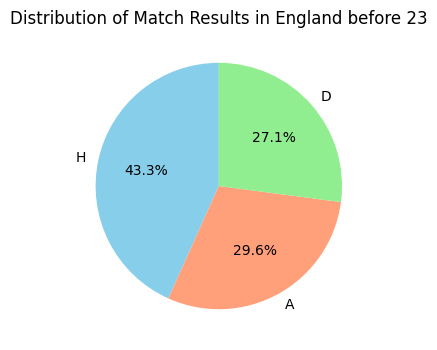

In [103]:
# Calculate value counts for 'result' column
result_counts = train['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England before 23")
plt.show()

In [104]:
X_train=train.drop(['label','FTR'], axis=1)
y_train=train['label']

In [105]:
test=seasons_df[seasons_df['season']=='season23']
test=test.copy()
test.drop('season', axis=1, inplace=True)

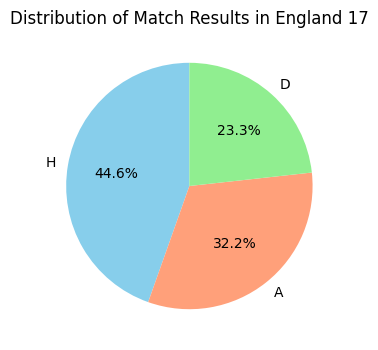

In [106]:
# Calculate value counts for 'result' column
result_counts = test['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England 17")
plt.show()

In [107]:
X_test=test.drop(['label', 'FTR'], axis=1)
y_test=test['label']

In [108]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [109]:
X_test

array([[-1.69184591e+00, -1.69135331e+00, -1.34634800e-01, ...,
        -1.25099228e-01, -1.55172323e-03, -3.57055130e-03],
       [-1.69184591e+00, -1.69135331e+00, -7.07126622e-01, ...,
         6.66512133e-01, -1.55172323e-03, -3.57055130e-03],
       [-1.69184591e+00, -1.69135331e+00, -3.25465407e-01, ...,
         6.05618952e-01, -1.55172323e-03, -3.57055130e-03],
       ...,
       [ 1.69263865e+00,  1.69171349e+00,  3.74246819e-01, ...,
        -6.42060467e-02, -1.94410627e-01, -5.35900078e-01],
       [ 1.69263865e+00,  1.69171349e+00, -4.52685812e-01, ...,
        -3.68671955e-01, -1.13998098e+00, -5.35900078e-01],
       [ 1.69263865e+00,  1.69171349e+00, -1.21600824e+00, ...,
         1.79366680e-01, -7.28049340e-01,  1.77086120e+00]])

### RandomForest

In [110]:
# Step 4: Train a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [111]:
# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.48


In [112]:
def evaluate_model(model, X_test, y_test, label_encoder):
    """
    Evaluate the model's performance using accuracy and a classification report.
    
    Parameters:
    model: The trained model
    X_test: Test features
    y_test: Actual labels for the test set
    label_encoder: The label encoder used to transform labels
    
    Returns:
    y_test_labels, y_pred_labels - The actual and predicted labels in original format
    """
    from sklearn.metrics import accuracy_score, classification_report
    
    # Step 1: Make predictions
    y_pred = model.predict(X_test)
    
    # Step 2: Convert predicted numeric labels back to original labels
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    
    # Step 3: Convert actual labels back to original labels
    y_test_labels = label_encoder.inverse_transform(y_test)
    
    # Step 4: Calculate and print accuracy
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    print(f"Model accuracy: {accuracy:.2f}")
    
    # Step 5: Generate and print classification report
    class_report = classification_report(y_test_labels, y_pred_labels)
    print("\nClassification Report:")
    print(class_report)

    return y_test_labels, y_pred_labels


In [68]:
y_test_labels, y_pred_labels = evaluate_model(model, X_test, y_test, label_encoder)

Model accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

           A       0.46      0.46      0.46       166
           D       0.39      0.12      0.18       120
           H       0.53      0.72      0.61       230

    accuracy                           0.50       516
   macro avg       0.46      0.43      0.42       516
weighted avg       0.48      0.50      0.46       516



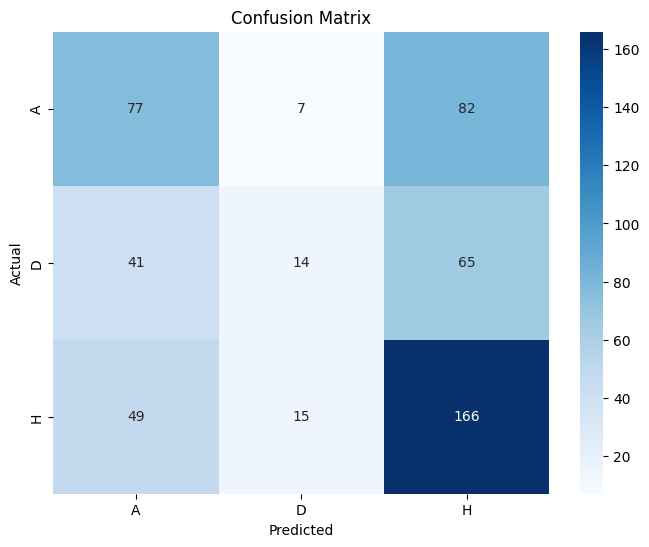

In [69]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [70]:
# Get feature importance from the model
feature_importances = model.feature_importances_

# Create a DataFrame to make it easier to read
feature_importance_df = pd.DataFrame({
    'Feature': train.drop(['label','FTR'], axis=1).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)
## Plot the feature importance
#plt.figure(figsize=(10, 6))
#plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
#plt.xlabel('Importance')
#plt.title('Feature Importance')
#plt.show()

                            Feature  Importance
21          diff.total.shots_target    0.024503
23               diff.total.corners    0.024167
19                 diff.total.shots    0.023852
10                             AvgA    0.023817
26      diff.total.fouls_other_team    0.023473
51                     diff.Balance    0.023468
25                 diff.total.fouls    0.023467
24      diff.total.corners_conceded    0.023336
20         diff.total.shots_against    0.022942
27               diff.total.yellows    0.022935
22  diff.total.shots_against_target    0.022909
15                 diff.total.goals    0.022478
17            diff.total.half_goals    0.022348
18         diff.total.half_conceded    0.022253
6                              AvgH    0.022138
50                      diff.grade2    0.022090
14                  diff.total.loss    0.022037
16              diff.total.conceded    0.021695
48         diff.total.loss.whenHorA    0.021275
28                  diff.total.reds    0

In [24]:
%%time
#Wall time: 14min 22s

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}



Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/benjamin/my_project_dir/my_project_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy'}
CPU times: user 14min 21s, sys: 917 ms, total: 14min 22s
Wall time: 14min 22s


In [ ]:
#%%time
#Wall time: 14min 22s

#random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_iter=5, verbose=1)
#random_search.fit(X_train, y_train)
#print(f'Best Parameters: {random_search.best_params_}')


In [114]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}

In [115]:
%%time
# Set up logging
logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)



# Custom function to log progress live
class LogProgress:
    def __init__(self, total):
        self.total = total
        self.current = 0

    def __call__(self, optim_result):
        self.current += 1
        params = optim_result.params
        mean_score = optim_result.mean_validation_score
        logging.info(f"Progress: {self.current}/{self.total} → {params} → Score: {mean_score:.4f}")

# Initialize and fit RandomizedSearchCV with live logging
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    cv=5,
    n_iter=20,  # Increase this for better search
    verbose=2,  # Show progress in console
    n_jobs=-1,  # Use all CPU cores
    return_train_score=True  # Store training scores as well
)

random_search.fit(X_train, y_train)

# Log results after completion
results = pd.DataFrame(random_search.cv_results_).sort_values(by="mean_test_score", ascending=False)
for i in results.index:
    params = results.loc[i, "params"]
    mean_score = results.loc[i, "mean_test_score"]
    logging.info(f"Final Results: {params} → Score: {mean_score:.4f}")

# Log best parameters
logging.info(f"Best Parameters: {random_search.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025-03-03 23:19:39,426 - Final Results: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 706} → Score: 0.4655
2025-03-03 23:19:39,427 - Final Results: {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 465} → Score: 0.4640
2025-03-03 23:19:39,429 - Final Results: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 18, 'n_estimators': 793} → Score: 0.4636
2025-03-03 23:19:39,430 - Final Results: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 687} → Score: 0.4634
2025-03-03 23:19:39,432 - Final Results: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 248} → Score: 0.4634
2025-03-03 23:19:39,433 - Final Results: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 109} → Score: 0.4628


CPU times: user 33.3 s, sys: 670 ms, total: 33.9 s
Wall time: 8min 5s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=3, min_samples_split=18, n_estimators=343; total time=  18.5s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=3, min_samples_split=18, n_estimators=343; total time=  21.6s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=1, min_samples_split=19, n_estimators=119; total time=   5.7s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=5, min_samples_split=13, n_estimators=200; total time=   7.1s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=5, min_samples_split=13, n_estimators=200; total time=   7.6s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=289; total time=  11.5s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=9, min_samples_split=11, n_estimators=538; total time=  21.7s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=6, min_samples_split=14, n_esti

In [116]:

# Get the best model
best_model = random_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
logging.info(f"Test Accuracy: {accuracy:.4f}")

# Optionally, print or log the classification report and confusion matrix
logging.info(f"Classification Report:\n{classification_report(y_test, y_pred)}")
logging.info(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

2025-03-03 23:24:22,686 - Test Accuracy: 0.4864
2025-03-03 23:24:22,696 - Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.47      0.45       166
           1       0.00      0.00      0.00       120
           2       0.52      0.75      0.62       230

    accuracy                           0.49       516
   macro avg       0.32      0.41      0.36       516
weighted avg       0.37      0.49      0.42       516

2025-03-03 23:24:22,700 - Confusion Matrix:
[[ 78   0  88]
 [ 49   0  71]
 [ 54   3 173]]


In [117]:
# Step 5: Evaluate the model
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.4864


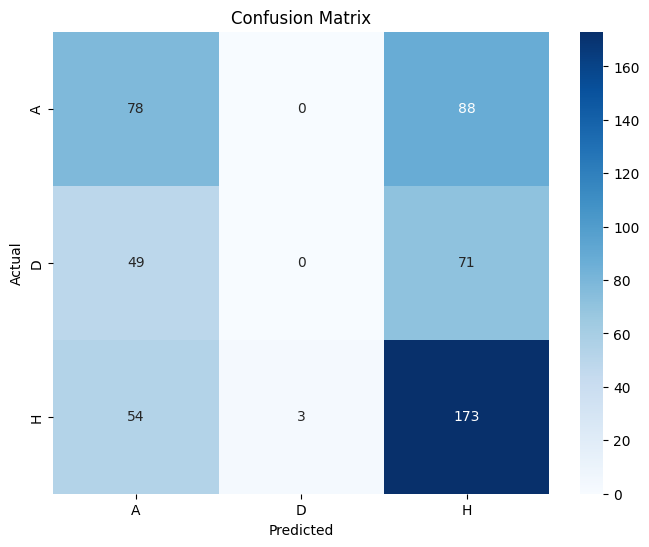

In [119]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [121]:
param_grid = {
    'criterion': ['gini', 'entropy'],  # Include both criteria (default is 'gini')
    'max_depth': [None, 10, 20],  # Keep the default value and a few smaller values
    'min_samples_leaf': [1, 2, 4],  # Include default (1) along with the best (2) and a reasonable option (4)
    'min_samples_split': [2, 6, 10],  # Include default (2) along with the best (6) and another reasonable value (10)
    'n_estimators': [100, 706, 1000]  # Include the default (100) and a couple of best values (706 and 1000)
}

In [ ]:

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV with the new parameter grid
grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Log the best parameters and score
logging.info(f"Best Parameters: {grid_search.best_params_}")
logging.info(f"Best Score: {grid_search.best_score_:.4f}")

# You can then log all results as you did with RandomizedSearchCV
results = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)
for i in results.index:
    params = results.loc[i, "params"]
    mean_score = results.loc[i, "mean_test_score"]
    logging.info(f"Final Results: {params} → Score: {mean_score:.4f}")

Fitting 5 folds for each of 1250 candidates, totalling 6250 fits


## XGBoost

In [26]:
# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [27]:
# Predict and evaluate
y_pred = model.predict(X_test)


In [29]:
y_test_labels, y_pred_labels = evaluate_model(model, X_test, y_test, label_encoder)

Model accuracy: 0.42

Classification Report:
              precision    recall  f1-score   support

           A       0.40      0.39      0.39       177
           D       0.19      0.09      0.12       129
           H       0.48      0.61      0.54       246

    accuracy                           0.42       552
   macro avg       0.35      0.37      0.35       552
weighted avg       0.39      0.42      0.40       552



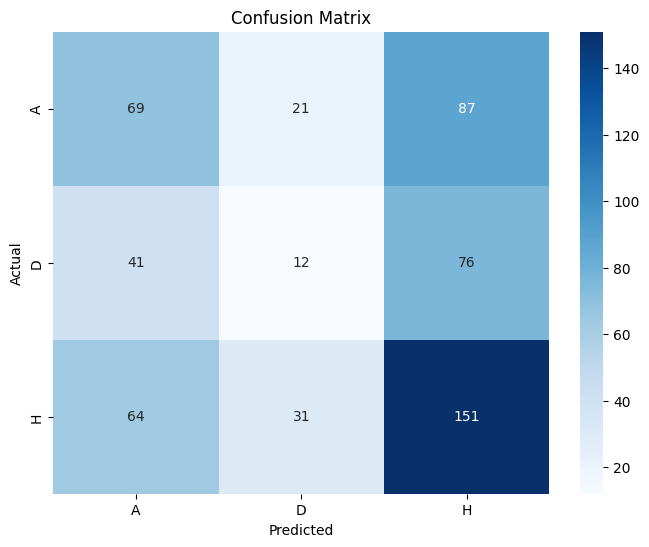

In [30]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [31]:
%%time
#Wall time: 2min 8s

# Define the model
model = xgb.XGBClassifier(random_state=42)



param_grid = {
    'n_estimators': randint(100, 1000),          # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),         # Learning rate
    'max_depth': randint(3, 10),                 # Max depth of tree
    'min_child_weight': randint(1, 10),          # Min child weight
    'subsample': uniform(0.5, 0.5),                # Fraction of samples used for each tree
    'colsample_bytree': uniform(0.5, 0.5),     # Fraction of features for each tree
    'gamma': uniform(0, 0.5),                    # Gamma (min loss reduction)
    'reg_alpha': uniform(0, 1),                  # L1 regularization term
    'reg_lambda': uniform(0, 1),                 # L2 regularization term
}

# Define the recall scorer for multiclass classification
#f1_scorer = make_scorer(f1_score, average='weighted')

# Initialize RandomizedSearchCV with the updated scorer
random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                   n_iter=30, cv=5, scoring='accuracy',
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters
print(f'Best Parameters: {random_search.best_params_}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.795446471594121, 'gamma': 0.3387821809211412, 'learning_rate': 0.014976348678356847, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 247, 'reg_alpha': 0.6451727904094499, 'reg_lambda': 0.17436642900499144, 'subsample': 0.845468869051233}
CPU times: user 22.6 s, sys: 952 ms, total: 23.5 s
Wall time: 4min 52s


In [33]:
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")


Model accuracy: 0.4873


In [37]:
# Define the model with the best parameters
model = xgb.XGBClassifier(
    colsample_bytree=0.795446471594121,
    gamma=0.3387821809211412,
    learning_rate=0.014976348678356847,
    max_depth=5,
    min_child_weight=3,
    n_estimators=247,
    reg_alpha=0.6451727904094499,
    reg_lambda=0.17436642900499144,
    subsample=0.845468869051233,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # Recommended for classification tasks
)

# Train the model
model.fit(X_train, y_train)

# Print confirmation
print("XGBoost model trained successfully with the best parameters!")

XGBoost model trained successfully with the best parameters!


In [38]:
y_test_labels, y_pred_labels = evaluate_model(model, X_test, y_test, label_encoder)

Model accuracy: 0.49

Classification Report:
              precision    recall  f1-score   support

           A       0.44      0.47      0.46       177
           D       0.25      0.02      0.04       129
           H       0.52      0.74      0.61       246

    accuracy                           0.49       552
   macro avg       0.40      0.41      0.37       552
weighted avg       0.43      0.49      0.43       552



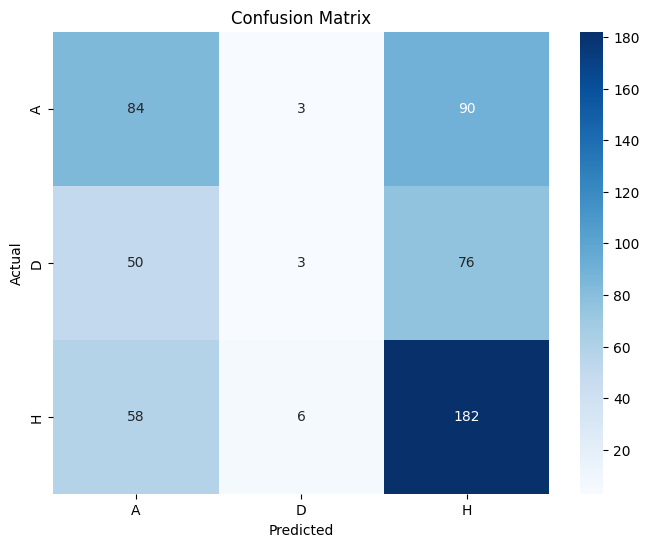

In [39]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()